# 0. Install Dependencies and Dataset

## 0.1 Install Python packages

In [ ]:
%%bash
rm -rf sample_data

pip -q install transformers
pip -q install datasets
pip -q install tqdm
pip -q install sentencepiece 
pip -q install kaggle
pip -q install sacrebleu


## 0.2 Download the dataset using the Kaggle API

In [ ]:
%%bash
mkdir ~/.kaggle/
cd ~/.kaggle/
touch kaggle.json
chmod 600 /root/.kaggle/kaggle.json
echo "{\"username\":\"cwcrystal8\",\"key\":\"75ba9516cfea9c5de8e657080f7428bd\"}" > kaggle.json

cd /content/

kaggle datasets download -d mateibejan/multilingual-lyrics-for-genre-classification
unzip multilingual-lyrics-for-genre-classification.zip
rm test.csv
rm multilingual-lyrics-for-genre-classification.zip
mv train.csv data.csv


Archive:  multilingual-lyrics-for-genre-classification.zip
  inflating: test.csv                
  inflating: train.csv               


100%|##########| 103M/103M [00:00<00:00, 150MB/s]


## 0.3 Clone the Github repo

In [ ]:
%%bash
cd /content/
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
rm -rf 6.864-lyric-analysis
git clone "https://github.com/sohinik/6.864-lyric-analysis.git"

Cloning into '6.864-lyric-analysis'...


# 1. Clean and Format the Data

In [ ]:
import numpy as np
import os
import random
import torch
from torch import cuda

os.chdir("/content/6.864-lyric-analysis")
print("Current Working Directory:", os.getcwd())

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if cuda.is_available():
  device = 'cuda'
  torch.cuda.manual_seed_all(seed)
else:
  print('WARNING: you are running this assignment on a cpu!')
  device = 'cpu'

Current Working Directory: /content/6.864-lyric-analysis


## 1.1 Get data from dataset

In [ ]:
import utils
from data_processing import get_data
from utils import save_model, load_model

## Data Hyperparameters
clean_genre=True
genres=["Jazz", "Metal"]
num_included=None
num_words_per_stanza = None # we don't want to separate stanzas since we need the entire song
training_ratio = 0.9

_, train_dict, test_dict = get_data("../data.csv", 
                                 clean_genre = clean_genre,
                                 genres = genres,
                                 num_included = num_included,
                                 num_words_per_stanza = num_words_per_stanza,
                                 training_ratio = training_ratio)

## 1.2 Get set of lyrics separated by newlines

In [ ]:
def get_lyric_set(lyrics):
  return set([line.lower() for song in lyrics for line in song.split("\n") if len(line.strip("(),./\\|{}<>-_`~'\":;?!#@$%^&*")) and 0 < song.strip().find("\n")])

def split_by_genre(lyrics, labels):
  genre_lyrics = {}
  for i in range(len(lyrics)):
    label = labels[i]
    if label in genre_lyrics:
      genre_lyrics[label].append(lyrics[i])
    else:
      genre_lyrics[label] = [lyrics[i]]
  for genre in genre_lyrics:
    genre_lyrics[genre] = get_lyric_set(genre_lyrics[genre])
  return genre_lyrics

genre_lyrics_train = split_by_genre(train_dict['lyrics'], train_dict['labels'])
genre_lyrics_test = split_by_genre(test_dict['lyrics'], test_dict['labels'])

In [ ]:
# train_dict['lyrics'] = [line.lower() for song in train_dict['lyrics'] for line in song.split("\n") if len(line.strip("(),./\\|{}<>-_`~'\":;?!#@$%^&*")) and 0 < song.strip().find("\n")]
# test_dict['lyrics'] = [line.lower() for song in test_dict['lyrics'] for line in song.split("\n") if len(line.strip("(),./\\|{}<>-_`~'\":;?!#@$%^&*")) and 0 < song.strip().find("\n")]

jazz_train = random.sample(genre_lyrics_train['Jazz'], 12000)
metal_train = random.sample(genre_lyrics_train['Metal'], 12000)
jazz_test = random.sample(genre_lyrics_test['Jazz'], 3000)
metal_test = random.sample(genre_lyrics_test['Metal'], 3000)

# train_dict['lyrics'] = train_dict['lyrics'][:15000]
# test_dict['lyrics'] = test_dict['lyrics'][:10000]


## 1.3 Define Dataset class

In [ ]:
from torch.utils import data
from collections import Counter

# These IDs are reserved.
PAD_INDEX = 0
UNK_INDEX = 1
SOS_INDEX = 2
EOS_INDEX = 3

MAX_SENT_LENGTH_PLUS_SOS_EOS = 90 # from max of folk and metal max lengths

def get_vocab(data_list, size=7000):
  word_freq = Counter(word.strip("(),./\\|{}<>-_`~'\":;?!#@$%^&*").lower() for lyrics in data_list for word in lyrics.split())
  del word_freq[""]
  # print(word_freq.most_common(20))
  return list(pair[0] for pair in word_freq.most_common(size))

class SongDataset(data.Dataset):
  def __init__(self, songs, vocab, max_size=None):
    self.max_src_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS
    self.songs = self.filter_songs(songs)
    self.v2id = {v : i + 4 for i, v in enumerate(vocab)}
    self.v2id['<pad>'] = PAD_INDEX
    self.v2id['<unk>'] = UNK_INDEX
    self.v2id['<sos>'] = SOS_INDEX
    self.v2id['<eos>'] = EOS_INDEX
    self.vocab = vocab
    self.vocab_size = len(self.v2id)
    self.id2v = {val : key for key, val in self.v2id.items()}

  def filter_songs(self, songs):
    filtered_songs = []
    for s in songs:
      song = s.lower().split()
      song_len = len(song) + 2   # add <s> and </s> to each sentence
      for word in song:
        w = word.strip("(),./\\|{}<>-_`~'\":;?!#@$%^&*")
        if not len(w):
          song_len -= 1
          continue
      if song_len < self.max_src_seq_length:
        filtered_songs.append(s)
    return filtered_songs
        

  def __len__(self):
    return len(self.songs)

  def __getitem__(self, index):
    return self.get_items(self.songs[index])

  def get_items(self, s):
    song = s.lower().split()
    song_len = len(song) + 2   # add <s> and </s> to each sentence
    song_ids = []
    for word in song:
      w = word.strip("(),./\\|{}<>-_`~'\":;?!#@$%^&*")
      if not len(w):
        song_len -= 1
        continue
      if w not in self.vocab:
        w = '<unk>'
      song_ids.append(self.v2id[w])
    song_ids = ([SOS_INDEX] + song_ids + [EOS_INDEX] + [PAD_INDEX] *
              (self.max_src_seq_length - song_len))
    attn_mask = ([1] * (song_len) + [0] * (self.max_src_seq_length - song_len))
    
    return torch.tensor(song_ids[:90]), torch.tensor(min(song_len, 90)), torch.tensor(attn_mask[:90])

## 1.4 Make datasets for each genre

In [ ]:
# vocabs = {genre: get_vocab(genre_lyrics_train[genre] | genre_lyrics_test[genre]) for genre in genre_lyrics_train.keys()}

# datasets_train = {genre: SongDataset(lyrics, vocabs[genre], max_size = None) for genre, lyrics in genre_lyrics_train.items()}
# datasets_test = {genre: SongDataset(lyrics, vocabs[genre], max_size = None) for genre, lyrics in genre_lyrics_test.items()}

# jazz_dataset_train = datasets_train["Jazz"]
# jazz_dataset_test = datasets_test["Jazz"]
# # metal_dataset_train = datasets_train["Metal"]
# metal_dataset_test = datasets_test["Metal"]

In [ ]:
# vocab = get_vocab(jazz_train + jazz_test + metal_train + metal_test)
# jazz_vocab = vocab
# metal_vocab = vocab
jazz_vocab = get_vocab(jazz_train + jazz_test)
metal_vocab = get_vocab(metal_train + metal_test)

jazz_songs = SongDataset(jazz_train, vocab)
metal_songs = SongDataset(metal_train, vocab)

In [ ]:
# del train_dict
# del test_dict
# del genre_lyrics_train
# del genre_lyrics_test
# del datasets_train
# del datasets_test

# 2. Design the Baseline Model


## 2.1 Encoder 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):
    """Encodes a sequence of word embeddings"""
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True, dropout=dropout)
        # self.rnn = nn.GRU(input_size, hidden_size, num_layers, 
        #                   batch_first=True, bidirectional=False, dropout=dropout)
        
    def forward(self, x, mask, lengths):
        """
        Applies a bidirectional GRU to sequence of embeddings x.
        The input mini-batch x needs to be sorted by length.
        x should have dimensions [batch, time, dim].
        """
        packed = pack_padded_sequence(x, lengths.to('cpu'), batch_first=True, enforce_sorted=False)
        output, final = self.rnn(packed)
        output, _ = pad_packed_sequence(output, batch_first=True, total_length=MAX_SENT_LENGTH_PLUS_SOS_EOS)

        # we need to manually concatenate the final states for both directions
        fwd_final = final[0:final.size(0):2]
        bwd_final = final[1:final.size(0):2]
        final = torch.cat([fwd_final, bwd_final], dim=2)  # [num_layers, batch, 2*dim]

        return output, final

## 2.2 Decoder

In [ ]:
class Decoder(nn.Module):
    """A conditional RNN decoder with attention."""
    
    def __init__(self, emb_size, hidden_size, attention=None, num_layers=1, dropout=0.5,
                 bridge=True):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.dropout = dropout
                 
        self.rnn = nn.GRU(emb_size + 2*hidden_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)

        # self.rnn = nn.GRU(emb_size, hidden_size, num_layers,
        #                   batch_first=True, dropout=dropout)
                 
        # to initialize from the final encoder state
        self.bridge = nn.Linear(2*hidden_size, hidden_size, bias=True) if bridge else None

        self.dropout_layer = nn.Dropout(p=dropout)
        self.pre_output_layer = nn.Linear(hidden_size + 2*hidden_size + emb_size,
                                          hidden_size, bias=False)
        # self.pre_output_layer = nn.Linear(hidden_size + emb_size,
        #                                    hidden_size, bias=False)
        
    def forward_step(self, prev_embed, encoder_hidden, src_mask, hidden, proj_key): #proj_key
        """Perform a single decoder step (1 word)"""


        # compute context vector using attention mechanism
        query = hidden[-1].unsqueeze(1)  # [#layers, B, D] -> [B, 1, D]

        context, attn_probs = self.attention(
            query=query, proj_key=proj_key,
            value=encoder_hidden, mask=src_mask)

        # update rnn hidden state
        rnn_input = torch.cat([prev_embed, context], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        # output, hidden = self.rnn(prev_embed, hidden)
        
        pre_output = torch.cat([prev_embed, output, context], dim=2)
        # pre_output = torch.cat([prev_embed, output], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)

        return output, hidden, pre_output
    
    def forward(self, trg_embed, encoder_hidden, encoder_final, 
                src_mask, trg_mask, hidden=None, max_len=None):
        """Unroll the decoder one step at a time."""
                                         
        # the maximum number of steps to unroll the RNN
        if max_len is None:
            # max_len = trg_mask.size(-1)
            max_len = trg_embed.size(1)

        # initialize decoder hidden state
        if hidden is None:
            hidden = self.init_hidden(encoder_final)
        
        # pre-compute projected encoder hidden states
        # (the "keys" for the attention mechanism)
        # this is only done for efficiency
        proj_key = self.attention.key_layer(encoder_hidden)
        
        # here we store all intermediate hidden states and pre-output vectors
        decoder_states = []
        pre_output_vectors = []
        
        # unroll the decoder RNN for max_len steps
        for i in range(max_len):

            # prev_embed = trg_embed[:, i].unsqueeze(1)
            prev_embed = trg_embed[:,i:i+1,:]
            pre_output, hidden, output = self.forward_step(
              prev_embed, encoder_hidden, src_mask, hidden, proj_key)
            decoder_states.append(output)
            pre_output_vectors.append(pre_output)

        decoder_states = torch.cat(decoder_states, dim=1)
        pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
        return decoder_states, hidden, pre_output_vectors  # [B, N, D]

    def init_hidden(self, encoder_final):
        """Returns the initial decoder state,
        conditioned on the final encoder state."""

        if encoder_final is None:
            return None  # start with zeros

        return torch.tanh(self.bridge(encoder_final))


## 2.3 Attention

In [ ]:
class BahdanauAttention(nn.Module):
    """Implements Bahdanau (MLP) attention"""
    
    def __init__(self, hidden_size, key_size=None, query_size=None):
        super(BahdanauAttention, self).__init__()
        
        # We assume a bi-directional encoder so key_size is 2*hidden_size
        key_size = 2 * hidden_size if key_size is None else key_size
        query_size = hidden_size if query_size is None else query_size

        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)
        
        # to store attention scores
        self.alphas = None
        
    def forward(self, query=None, proj_key=None, value=None, mask=None):
        assert mask is not None, "mask is required"
        
        # We first project the query (the decoder state).
        # The projected keys (the encoder states) were already pre-computated.
        query = self.query_layer(query)
        
        # Calculate scores.
        scores = self.energy_layer(torch.tanh(query + proj_key))
        scores = scores.squeeze(2).unsqueeze(1)
        
        # Mask out invalid positions.
        # The mask marks valid positions so we invert it using `mask & 0`.
        scores.data.masked_fill_(mask == 0, -float('inf'))
        
        # Turn scores to probabilities.
        alphas = F.softmax(scores, dim=-1)
        self.alphas = alphas        
        
        # The context vector is the weighted sum of the values.
        context = torch.bmm(alphas, value)
        
        # context shape: [B, 1, 2D], alphas shape: [B, 1, M]
        return context, alphas

## 2.4 EncoderDecoderLyricGenerator

In [ ]:
class EncoderDecoderLyricGenerator(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """

    def __init__(self, encoder, decoder, generator, src_embed, trg_embed):
        super(EncoderDecoderLyricGenerator, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.generator = generator
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        
    def forward(self, src, trg, src_mask, trg_mask, src_lengths, trg_lengths):
        """Take in and process masked src and target sequences."""
        encoder_hidden, encoder_final = self.encode(src, src_mask, src_lengths)
        return self.decode(encoder_hidden, encoder_final, src_mask, trg[:,:-1], trg_mask)
    
    def encode(self, src, src_mask, src_lengths):
        return self.encoder(self.src_embed(src), src_mask, src_lengths)
    
    def decode(self, encoder_hidden, encoder_final, src_mask, trg, trg_mask,
               decoder_hidden=None):
        return self.decoder(self.trg_embed(trg), encoder_hidden, encoder_final,
                            src_mask, trg_mask, hidden=decoder_hidden)
        
    def get_generated_text(self, decoded):
        return self.generator(decoded)

class Generator(nn.Module):
        """Define standard linear + softmax generation step."""
        def __init__(self, hidden_size, vocab_size):
            super(Generator, self).__init__()
            self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

        def forward(self, x):
            return F.log_softmax(self.proj(x), dim=-1)

# 3. Train the Model

## 3.1 Create the model

In [ ]:
emb_size=256
hidden_size=256
num_layers=2
dropout=0.2

jazz_vocab_size = jazz_songs.vocab_size
metal_vocab_size = metal_songs.vocab_size

jazz_model = EncoderDecoderLyricGenerator(
        Encoder(emb_size, hidden_size, dropout=dropout, num_layers=num_layers),
        Decoder(emb_size, hidden_size, attention=BahdanauAttention(hidden_size),dropout=dropout,num_layers=num_layers),
        Generator(hidden_size, jazz_vocab_size),
        nn.Embedding(jazz_vocab_size, emb_size),
        nn.Embedding(jazz_vocab_size, emb_size), 
        ).to(device)

metal_model = EncoderDecoderLyricGenerator(
        Encoder(emb_size, hidden_size, dropout=dropout, num_layers=num_layers),
        Decoder(emb_size, hidden_size, attention=BahdanauAttention(hidden_size),dropout=dropout,num_layers=num_layers),
        Generator(hidden_size, metal_vocab_size),
        nn.Embedding(metal_vocab_size, emb_size),
        nn.Embedding(metal_vocab_size, emb_size), 
        ).to(device)

In [ ]:
assert jazz_vocab_size == metal_vocab_size # the two vocabs should be the same
assert jazz_vocab == metal_vocab

## 3.2 Set the hyperparameters

In [ ]:
# Hyper-parameters: you could try playing with different settings
num_epochs = 10
learning_rate = 1e-3
batch_size = 16

## 3.3 Define loss function

In [ ]:
class SelfLoss:
    """A self loss compute and train function."""

    def __init__(self, generator, criterion, opt=None):
      self.generator = generator
      self.criterion = criterion
      self.opt = opt

    def __call__(self, x, y, norm=1):
        '''
        x: output of our encoder-decoder (logits of each word)
        y: input of our encoder-decoder
        '''
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss = loss / norm

        if self.opt is not None:
            loss.backward()          
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm

In [ ]:
def run_epoch(data_loader, model, loss_compute, print_every):
  total_tokens = 0
  total_loss = []

  for i, (song_ids, song_lengths, song_attn) in enumerate(data_loader):

    song_ids=song_ids.to(device)
    song_lengths=song_lengths.to(device)
    song_attn = song_attn.to(device)
    song_attn = song_attn.unsqueeze(-2)
    
    _, _, output = model(song_ids, song_ids, song_attn, song_attn, song_lengths, song_lengths)

    loss = loss_compute(x=output, y=song_ids[:, 1:],
                        norm=song_ids.size(0))
    total_loss.append(loss)

    if model.training and i % print_every == 0:
      print("Epoch Step: %d Loss: %f" % (i, loss / song_ids.size(0)))

  return total_loss


## 3.4 Train

In [ ]:
train = False
print_every = 100

if train:
  
  # jazz_data_loader = data.DataLoader(jazz_songs, batch_size=batch_size, shuffle=True, num_workers=2)
  metal_data_loader = data.DataLoader(metal_songs, batch_size=batch_size, shuffle=True, num_workers=2)

  # print("Number of total steps:", len(jazz_data_loader))
  print("Number of total steps:", len(metal_data_loader))

  criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)

  # jazz_optim = torch.optim.Adam(jazz_model.parameters(), lr=learning_rate)
  metal_optim = torch.optim.Adam(metal_model.parameters(), lr=learning_rate)
  
  # jazz_loss_fn = SelfLoss(jazz_model.generator,criterion, jazz_optim)
  metal_loss_fn = SelfLoss(metal_model.generator,criterion, metal_optim)

  # jazz_losses = []
  metal_losses = []

  # print("Jazz model training")
  # for epoch in range(num_epochs):
  #   print(f"Epoch number {epoch}-------")
  #   jazz_model.train()
  #   jazz_losses.extend(run_epoch(data_loader=jazz_data_loader, model=jazz_model,
  #               loss_compute=jazz_loss_fn,
  #               print_every=print_every))
  # print('Jazz model training complete')  
  # utils.save_model(jazz_model, "/content/jazz_autoencoder.pt")

  print("Metal model training")
  for epoch in range(num_epochs):
    print(f"Epoch number {epoch}-------")

    metal_model.train()
    metal_losses.extend(run_epoch(data_loader=metal_data_loader, model=metal_model,
                loss_compute=metal_loss_fn,
                print_every=print_every))
  print('Metal model training complete') 
  utils.save_model(metal_model, "/content/metal_autoencoder.pt") 

else:
  jazz_model.load_state_dict(torch.load("/content/jazz_autoencoder.pt"))
  metal_model.load_state_dict(torch.load("/content/metal_autoencoder.pt"))


No handles with labels found to put in legend.


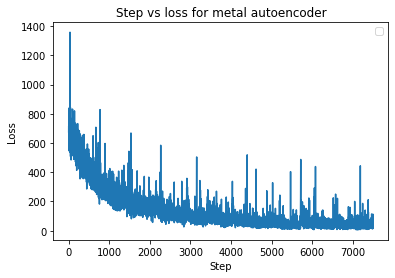

In [ ]:
import matplotlib.pyplot as plt

if train:

  plt.plot(metal_losses)
  plt.legend()
  plt.xlabel("Step")
  plt.ylabel("Loss")
  plt.title("Step vs loss for metal autoencoder")
  plt.show()

In [ ]:
# utils.save_model(jazz_model, "/content/jazz_model_3_epochs_10000_datapoints.pt")

# 4. Evaluate the Model


## 4.1 Define test dataset

In [ ]:
test_batch_size = 1

jazz_songs_test = SongDataset(jazz_test, jazz_vocab)
data_loader_jazz_test = data.DataLoader(jazz_songs_test, batch_size=test_batch_size, shuffle=True)

metal_songs_test = SongDataset(metal_test, metal_vocab)
data_loader_metal_test = data.DataLoader(metal_songs_test, batch_size=test_batch_size, shuffle=True)

## 4.2 Greedy decode for qualitative analysis

In [ ]:
def decode_to_string(ids, dataset):
  words = [dataset.id2v[i.item()] for i in ids]
  return " ".join(words)

In [ ]:
def greedy_decode(model, src_ids, src_lengths, src_mask, max_len):
  """Greedily decode a sentence for EncoderDecoder. Make sure to chop off the 
     EOS token!"""

  with torch.no_grad():
    encoder_hidden, encoder_finals = model.encode(src_ids, src_mask, src_lengths)
    prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)
    mask = torch.ones(1, 1).type_as(src_ids)

  output = []
  hidden = None
  
  # --------- Your code here --------- #
  for i in range(max_len):
    outputs, hidden, cur_output = model.decode(encoder_hidden, encoder_finals, src_mask, prev_y, mask, hidden)
    cur_output = model.generator(cur_output)
    max_x = torch.argmax(cur_output, dim=2).item()
    # best = cur_output[0][0][max_x]
    if max_x == EOS_INDEX:
      break
    output.append(max_x)
    prev_y = torch.ones(1, 1).fill_(max_x).type_as(src_ids)
  

  # --------- Your code ends --------- #

  return torch.Tensor(output)

In [ ]:
def greedy_decode_text_style_transfer(encode_model, decode_model, src_ids, src_lengths, src_mask, max_len):
  """Greedily decode a sentence for EncoderDecoder. Make sure to chop off the 
     EOS token!"""

  with torch.no_grad():
    encoder_hidden, encoder_finals = encode_model.encode(src_ids, src_mask, src_lengths)
    prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)
    mask = torch.ones(1, 1).type_as(src_ids)

  output = []
  hidden = None
  
  # --------- Your code here --------- #
  for i in range(max_len):
    outputs, hidden, cur_output = decode_model.decode(encoder_hidden, encoder_finals, src_mask, prev_y, mask, hidden)
    cur_output = decode_model.generator(cur_output)
    max_x = torch.argmax(cur_output, dim=2).item()
    # best = cur_output[0][0][max_x]
    if max_x == EOS_INDEX:
      break
    output.append(max_x)
    prev_y = torch.ones(1, 1).fill_(max_x).type_as(src_ids)
  

  # --------- Your code ends --------- #

  return torch.Tensor(output)

In [ ]:
jazz_model.eval()
# metal_model.eval()

total_loss = 0

# confusion_matrix = torch.zeros((num_labels, num_labels)).to(device)
num_test_batches = 0

for i, (song_ids, song_lengths, song_attn) in enumerate(data_loader_jazz_test):

    if i > 5:
      continue

    song_ids = song_ids.to(device)
    song_attn = song_attn.to(device)

    # output = greedy_decode(model, song_ids, song_lengths, song_attn, MAX_SENT_LENGTH_PLUS_SOS_EOS)
    output = greedy_decode(jazz_model, song_ids, song_lengths, song_attn, MAX_SENT_LENGTH_PLUS_SOS_EOS)
    print("input:", decode_to_string(song_ids[0,1:song_lengths-1], jazz_songs_test))
    print("output:", decode_to_string(output, jazz_songs_test))
    print()

'''
    
    # Back-propagate the loss signal and clip the gradients
    total_loss += outputs.loss.mean()

    # Update confusion matrix
    logits = outputs.logits
    predictions = torch.argmax(logits, dim = 1)
    for label, pred in zip(batch_labels, predictions):
      confusion_matrix[label, pred] += 1

    num_test_batches += 1

avg_test_loss = total_loss / num_test_batches
print(f'The test loss is {avg_test_loss}')
'''
print()

input: i guess he's not for me
output: i guess he's not for me

input: they got a crazy way of loving there
output: they got a crazy way of loving there

input: i watch where i venture see
output: i watch where i take see

input: and where there where there was hope
output: and where there where there was hope

input: always seems to me
output: always seems to me

input: now ain't it peculiar that she's finally <unk> your
output: now ain't it couldn't that she's right <unk>




In [ ]:
metal_model.eval()

total_loss = 0

# confusion_matrix = torch.zeros((num_labels, num_labels)).to(device)
num_test_batches = 0

for i, (song_ids, song_lengths, song_attn) in enumerate(data_loader_metal_test):

    if i > 5:
      continue

    song_ids = song_ids.to(device)
    song_attn = song_attn.to(device)

    # output = greedy_decode(model, song_ids, song_lengths, song_attn, MAX_SENT_LENGTH_PLUS_SOS_EOS)
    output = greedy_decode(metal_model, song_ids, song_lengths, song_attn, MAX_SENT_LENGTH_PLUS_SOS_EOS)
    print("input:", decode_to_string(song_ids[0,1:song_lengths-1], metal_songs_test))
    print("output:", decode_to_string(output, metal_songs_test))
    print()

'''
    
    # Back-propagate the loss signal and clip the gradients
    total_loss += outputs.loss.mean()

    # Update confusion matrix
    logits = outputs.logits
    predictions = torch.argmax(logits, dim = 1)
    for label, pred in zip(batch_labels, predictions):
      confusion_matrix[label, pred] += 1

    num_test_batches += 1

avg_test_loss = total_loss / num_test_batches
print(f'The test loss is {avg_test_loss}')
'''
print()

input: better better run
output: better better run

input: find the real
output: find the real

input: the right drug wrong time he'll be remembered
output: the right drug wrong time he'll be help

input: i don't belong here
output: i don't belong here

input: but she chose to push them away
output: but she chose to push them away

input: a boy was born poor and abandoned
output: a boy was born ticket and abandoned




## 4.3 Calculating BLEU scores for the two models

In [ ]:
import sacrebleu
from tqdm import tqdm

def compute_BLEU(model, data_loader, decoder, dataset):

  bleu_score = []

  model.eval()
  for src_ids, src_lengths, src_mask in tqdm(data_loader):
    result = decoder(model, src_ids.to(device), src_lengths.to(device), src_mask.to(device),
                         max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS)
    
    # remove <s>
    src_ids = src_ids[0, 1:]
    # remove </s> and <pad>
    src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]

    pred = decode_to_string(result, dataset)
    targ = decode_to_string(src_ids, dataset)

    if targ:
      bleu_score.append(sacrebleu.raw_corpus_bleu([pred], [[targ]]).score)

  return bleu_score

In [ ]:
print('Jazz BLEU score: %f' % (np.mean(compute_BLEU(jazz_model, 
                                            data_loader_jazz_test,
                                            greedy_decode, jazz_songs_test))))
print('Metal BLEU score: %f' % (np.mean(compute_BLEU(metal_model, 
                                            data_loader_metal_test,
                                            greedy_decode, metal_songs_test))))

In [ ]:
def compute_BLEU_cycle(starting_model, intermediate_model, data_loader, decoder, og_dataset, intermediate_dataset):

  bleu_score = []

  starting_model.eval()
  intermediate_model.eval()
  for src_ids, src_lengths, src_mask in tqdm(data_loader):
    int_result = decoder(starting_model, intermediate_model, src_ids.to(device), src_lengths.to(device), src_mask.to(device),
                         max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS)
    
    int_result = decode_to_string(int_result, intermediate_dataset)
    
    new_ids, new_lengths, new_mask = intermediate_dataset.get_items(int_result)

    new_ids = new_ids[None,:]
    new_lengths = new_lengths[None]
    new_mask = new_mask[None,:]

    # print(new_ids.shape, new_mask.shape, new_lengths.shape)
    result = decoder(intermediate_model, starting_model, new_ids.to(device), new_lengths.to(device), new_mask.to(device),
                         max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS)
    
    # remove <s>
    src_ids = src_ids[0, 1:]
    # remove </s> and <pad>
    src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]

    pred = decode_to_string(result, og_dataset)
    targ = decode_to_string(src_ids, og_dataset)

    if targ:
      bleu_score.append(sacrebleu.raw_corpus_bleu([pred], [[targ]]).score)

  return bleu_score

In [ ]:
print('\nJazz -> Metal -> Jazz BLEU score: %f' % (np.mean(compute_BLEU_cycle(jazz_model, metal_model,
                                            data_loader_jazz_test,
                                            greedy_decode_text_style_transfer, jazz_songs_test, metal_songs_test))))
print('\nMetal -> Jazz -> Metal BLEU score: %f' % (np.mean(compute_BLEU_cycle(metal_model, jazz_model,
                                            data_loader_metal_test,
                                            greedy_decode_text_style_transfer, metal_songs_test, jazz_songs_test))))

## 4.2 Calculate the accuracy, precision, and recall with our classification model

Load in the classification model

In [ ]:
from classification import make_pretrained_model, evaluate, selective_evaluate

classification_model = make_pretrained_model().to(device)
classification_model.load_state_dict(torch.load("/content/transformer_classification_model.pt"))

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
def get_prediction(starting_model, ending_model, data_loader, decoder, og_dataset, ending_dataset):

  starting_model.eval()
  ending_model.eval()

  preds = []

  for src_ids, src_lengths, src_mask in tqdm(data_loader):
    result = decoder(starting_model, ending_model, src_ids.to(device), src_lengths.to(device), src_mask.to(device),
                         max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS)

    src_ids = src_ids[0, 1:]
    # remove </s> and <pad>
    src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
    src = decode_to_string(src_ids, og_dataset)

    result = decode_to_string(result, ending_dataset)
    preds.append(result)

  return preds

In [ ]:
jazz_to_metal_preds = get_prediction(jazz_model, metal_model, data_loader_jazz_test,
                       greedy_decode_text_style_transfer, jazz_songs_test, metal_songs_test)
metal_to_jazz_preds = get_prediction(metal_model, jazz_model, data_loader_metal_test,
                       greedy_decode_text_style_transfer, metal_songs_test, jazz_songs_test)

100%|██████████| 3000/3000 [02:14<00:00, 22.24it/s]


In [ ]:
all_preds = jazz_to_metal_preds + metal_to_jazz_preds

jazz_to_metal_labels = ["Metal"] * len(jazz_to_metal_preds)
metal_to_jazz_labels = ["Jazz"] * len(metal_to_jazz_preds)
all_labels = jazz_to_metal_labels + metal_to_jazz_labels

assert len(all_preds) == len(all_labels)

In [ ]:
loss, confusion_matrix = evaluate(classification_model, all_preds, all_labels) # general argmax, no selectivity

In [ ]:
from data_analysis import get_accuracy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

def plot_confusion_matrix(confusion_matrix, all_labels = None):
  if all_labels is None:
    all_labels = ["Country", "Folk", "Jazz", "Hip-Hop", "Metal", "Pop"]

  all_labels.sort()

  jazz_metal_confusion_matrix = confusion_matrix[3:5, :]
  df_cm = pd.DataFrame(jazz_metal_confusion_matrix.cpu().numpy(),
                     index = all_labels[3:5],
                     columns = all_labels)

  plt.figure(figsize = (10,2.5))
  sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
  plt.ylabel("Actual")
  plt.xlabel("Predicted")

plot_confusion_matrix(confusion_matrix)

In [ ]:
# def selective_evaluate(model, inputs, labels, num_labels = 6, batch_size = 16, device = "cuda"):
#   """
#   Inputs:
#   model: an instance of GenreClassificationModel
#   inputs: a list of strings where each string is a lyric
#   labels: a list of strings where each string is the correct genre
#   num_labels: the total number of labels (leave as default for pretrained model)
#   device: the runtime device

#   Outputs:
#   avg_test_loss: the average test loss over all batches
#   confusion_matrix: the confusion matrix
#   """
#   tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-cased')
#   labels = get_ids_for_labels(labels)

#   model.eval()

#   num_data = len(labels)
#   batch_size = 16 # batch_size is entire
#   num_batches = 0

#   total_loss = 0
#   confusion_matrix = torch.zeros((num_labels, num_labels)).to(device)

#   for i in range(0, num_data, batch_size):
#       batch_inputs = inputs[i: i + batch_size]
#       batch_labels = labels[i: i + batch_size]

#       batch_ids, batch_labels, batch_attn_mask = vectorize_batch(batch_inputs, batch_labels, tokenizer)

#       with torch.no_grad():
#         outputs = model(
#             batch_ids,
#             batch_attn_mask,
#             batch_labels
#         )

#       # Back-propagate the loss signal and clip the gradients
#       total_loss += outputs.loss.mean()

#       # Update confusion matrix
#       logits = outputs.logits

#       # mask out irrelvant indices
#       indices_to_keep = [3, 4]
#       for i in range(6):
#         if i not in indices_to_keep:
#           logits[: ,i] -= float("inf")
          
#       predictions = torch.argmax(logits, dim = 1)
#       for _, label, pred in zip(batch_inputs, batch_labels, predictions):
#         confusion_matrix[label, pred] += 1

#       num_batches += 1

#   avg_test_loss = total_loss / num_batches
#   return avg_test_loss, confusion_matrix

In [ ]:
selective_loss, selective_confusion_matrix = selective_evaluate(classification_model, all_preds, all_labels) # selective argmax

In [ ]:
def plot_jazz_metal_confusion_matrix(confusion_matrix, all_labels = None):
  if all_labels is None:
    all_labels = ["Jazz",  "Metal"]

  all_labels.sort()

  jazz_metal_confusion_matrix = confusion_matrix[3:5, 3:5]
  df_cm = pd.DataFrame(jazz_metal_confusion_matrix.cpu().numpy(),
                     index = all_labels,
                     columns = all_labels)

  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
  plt.ylabel("Actual")
  plt.xlabel("Predicted")

plot_jazz_metal_confusion_matrix(selective_confusion_matrix)

In [ ]:
print("general argmax accuracy",  get_accuracy(confusion_matrix))
print("selective argmax accuracy", get_accuracy(selective_confusion_matrix))

general argmax accuracy tensor(0.2658, device='cuda:0')
selective argmax accuracy tensor(0.6975, device='cuda:0')


## 4.3 Qualitative Analysis

In [ ]:
def sample_prediction(starting_model, ending_model, data_loader, decoder, og_dataset, ending_dataset, src_label, end_label, num_examples = 5):

  starting_model.eval()
  ending_model.eval()

  preds = []

  i = 0

  for src_ids, src_lengths, src_mask in data_loader:
    result = decoder(starting_model, ending_model, src_ids.to(device), src_lengths.to(device), src_mask.to(device),
                         max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS)

    src_ids = src_ids[0, 1:]
    # remove </s> and <pad>
    src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
    src = decode_to_string(src_ids, og_dataset)

    result = decode_to_string(result, ending_dataset)
    preds.append(result)

    print()
    print((len("Predicted ") + len(end_label) - len(src_label)) * " " + f"{src_label}:", src)
    print(f"Predicted {end_label}:", preds[-1])

    i += 1
    if i > num_examples:
      break

  return preds

In [ ]:
print("jazz to metal predictions")
jazz_to_metal_preds = sample_prediction(jazz_model, metal_model, data_loader_jazz_test,
                       greedy_decode_text_style_transfer, jazz_songs_test, metal_songs_test,
                       "Jazz", "Metal")

print("\n\nmetal to jazz predictions")
metel_to_jazz_preds = sample_prediction(metal_model, jazz_model, data_loader_metal_test,
                       greedy_decode_text_style_transfer, metal_songs_test, jazz_songs_test,
                       "Metal", "Jazz")

jazz to metal predictions

           Jazz: i may dream a million dreams
Predicted Metal: the breaking that i falling see what's

           Jazz: and what we have is much more than they could see
Predicted Metal: one again through black every you loved every else

           Jazz: stay little valentine stay
Predicted Metal: ever truth see go before

           Jazz: than right here with you loving me
Predicted Metal: around we strong know no of bringing

           Jazz: i get me out of bed and sing this crazy song
Predicted Metal: you down see you'll from before hear see new

           Jazz: what joy a perfect holiday
Predicted Metal: grave fuck see thing as am


metal to jazz predictions

         Metal: throws itself high up in the sky
Predicted Jazz: long no hold to si

         Metal: won't you come <unk> girl
Predicted Jazz: are know wings to she's

         Metal: be careful what you wish for when you dream
Predicted Jazz: all rock so know small it your

         Metal: a <unk